In [1]:
# =========================
# 0) Imports y utilidades
# =========================
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# --- utilidades pequeñas ---

def _resolve_sim_paths(sim_dir: str | Path,
                       excel_name: str = "episodes_summary_data.xlsx",
                       metadata_name: str = "metadata_simulation_run.json"
                       ) -> Tuple[Path, Optional[Path]]:
    """
    Devuelve (excel_path, metadata_path or None).
    Busca ambos dentro de sim_dir.
    """
    sim_dir = Path(sim_dir)
    excel_path = sim_dir / excel_name
    if not excel_path.exists():
        # fallback: busca un xlsx dentro de la carpeta
        cands = list(sim_dir.glob("*.xlsx"))
        if not cands:
            raise FileNotFoundError(f"No encontré '{excel_name}' ni ningún .xlsx en {sim_dir}")
        excel_path = cands[0]
    metadata_path = sim_dir / metadata_name
    if not metadata_path.exists():
        metadata_path = None
    return excel_path, metadata_path


def _present(df: pd.DataFrame, names: List[str]) -> List[str]:
    "Filtra por columnas presentes (case sensitive)."
    return [c for c in names if c in df.columns]


def _first_present(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    "Devuelve la primera columna existente entre candidatas."
    for c in candidates:
        if c in df.columns:
            return c
    return None


def _make_out_dir(sim_dir: str | Path, out_dir: Optional[str | Path]) -> Optional[Path]:
    if out_dir is None:
        return None
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir


def _savefig(fig: plt.Figure, out_dir: Optional[Path], name: str, dpi: int = 150):
    if out_dir is None:
        return
    fig.savefig(out_dir / f"{name}.png", dpi=dpi, bbox_inches="tight")


In [2]:
# ==========================================
# 1) Carga y derivados de métricas por episodio
# ==========================================
import json

def load_episodes_summary(sim_dir: str | Path,
                          excel_name: str = "episodes_summary_data.xlsx",
                          read_metadata: bool = True
                          ) -> Tuple[pd.DataFrame, Dict]:
    """
    Carga el Excel de episodios y, si está, un metadata JSON.
    Ordena por 'episode' si existe.
    """
    xlsx_path, meta_path = _resolve_sim_paths(sim_dir, excel_name=excel_name)
    df = pd.read_excel(xlsx_path)
    if 'episode' in df.columns:
        df = df.sort_values('episode').reset_index(drop=True)
    meta = {}
    if read_metadata and meta_path is not None:
        try:
            meta = json.loads(meta_path.read_text(encoding="utf-8"))
        except Exception:
            meta = {}
    return df, meta


def derive_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Añade métricas derivadas livianas por episodio.
    - u_drop = u_max - u_p75  (caída tras saturación)
    - u_floor = u_p25 - u_min (micro-patadas bajas)
    - rate_align_p50 = level_rate_p50 - target_level_rate_p50
    - rate_align_rmse_proxy con (p25,p50,p75)
    - goal_reached_flag (si existe 'termination_reason')
    """
    df = df.copy()

    # --- señales de control normalizadas (nombres con o sin '_pXX')
    u_max = _first_present(df, ["normalize_control_action_max"])
    u_min = _first_present(df, ["normalize_control_action_min"])
    u_p25 = _first_present(df, ["normalize_control_action_p25", "normalize_control_actionp25"])
    u_p50 = _first_present(df, ["normalize_control_action_p50", "normalize_control_actionp50"])
    u_p75 = _first_present(df, ["normalize_control_action_p75", "normalize_control_actionp75"])

    if u_max and u_p75:
        df["u_drop"] = df[u_max] - df[u_p75]
    else:
        df["u_drop"] = np.nan

    if u_p25 and u_min:
        df["u_floor"] = df[u_p25] - df[u_min]
    else:
        df["u_floor"] = np.nan

    # --- alineación de velocidades
    lr_p25 = _first_present(df, ["level_rate_p25", "level_ratep25"])
    lr_p50 = _first_present(df, ["level_rate_p50", "level_ratep50"])
    lr_p75 = _first_present(df, ["level_rate_p75", "level_ratep75"])
    tr_p25 = _first_present(df, ["target_level_rate_p25", "target_level_ratep25"])
    tr_p50 = _first_present(df, ["target_level_rate_p50", "target_level_ratep50"])
    tr_p75 = _first_present(df, ["target_level_rate_p75", "target_level_ratep75"])

    if lr_p50 and tr_p50:
        df["rate_align_p50"] = df[lr_p50] - df[tr_p50]
    else:
        df["rate_align_p50"] = np.nan

    if all([lr_p25, lr_p50, lr_p75, tr_p25, tr_p50, tr_p75]):
        diffs2 = (df[lr_p25] - df[tr_p25])**2 + (df[lr_p50] - df[tr_p50])**2 + (df[lr_p75] - df[tr_p75])**2
        df["rate_align_rmse_proxy"] = np.sqrt(diffs2 / 3.0)
    else:
        df["rate_align_rmse_proxy"] = np.nan

    # --- flags de outcome
    if "termination_reason" in df.columns:
        df["goal_reached_flag"] = (df["termination_reason"] == "goal_reached").astype(int)
        df["time_limit_flag"] = (df["termination_reason"] == "time_limit").astype(int)
        df["agent_early_flag"] = (df["termination_reason"] == "agent_early_termination").astype(int)
    else:
        for c in ["goal_reached_flag", "time_limit_flag", "agent_early_flag"]:
            df[c] = np.nan

    return df


In [3]:
# ==========================================
# 2) Tablas resumen (T1–T6)
# ==========================================
def _episode_blocks(df: pd.DataFrame, block_size: int = 1000) -> pd.Series:
    if "episode" in df.columns:
        return (df["episode"] // block_size).astype(int)
    # fallback: índice como episodio
    return (pd.Series(np.arange(len(df)), index=df.index) // block_size).astype(int)


def make_tables(df: pd.DataFrame, block_size: int = 1000) -> Dict[str, pd.DataFrame]:
    """
    Devuelve un dict con tablas T1–T6.
    """
    out: Dict[str, pd.DataFrame] = {}

    # --- T1: Resumen global
    cols_exist = _present(df, ["total_reward", "performance", "epsilon", "learning_rate"])
    t1 = pd.DataFrame({
        "n_episodes": [len(df)],
        "%goal_reached": [df.get("goal_reached_flag", pd.Series([np.nan]*len(df))).mean() * 100],
        "%time_limit": [df.get("time_limit_flag", pd.Series([np.nan]*len(df))).mean() * 100],
        "%agent_early": [df.get("agent_early_flag", pd.Series([np.nan]*len(df))).mean() * 100],
    })
    if "total_reward" in df.columns:
        t1["total_reward_mean"] = df["total_reward"].mean()
        t1["total_reward_std"]  = df["total_reward"].std()
    if "performance" in df.columns:
        t1["performance_mean"] = df["performance"].mean()
        t1["performance_std"]  = df["performance"].std()
    if "epsilon" in df.columns:
        t1["epsilon_p50"]      = df["epsilon"].median()
    if "learning_rate" in df.columns:
        t1["learning_rate_p50"]= df["learning_rate"].median()
    out["T1_global"] = t1

    # --- T2: Por razón de término
    if "termination_reason" in df.columns:
        agg_cols = _present(df, [
            "total_reward", "performance",
            "final_kp", "final_ki", "final_kd",
            "normalize_control_action_max", "normalize_control_action_min", "normalize_control_action_mean",
            "reward_penalty_delta_control_action_mean", "reward_dp_control_action_mean",
        ])
        t2 = (df
              .groupby("termination_reason")[agg_cols]
              .agg(["count","mean","median"]))
        out["T2_by_outcome"] = t2

    # --- T3: Por bloques de episodios (progreso)
    blocks = _episode_blocks(df, block_size)
    agg_cols3 = _present(df, [
        "goal_reached_flag", "total_reward", "performance",
        "final_kd", "final_kp",
        "reward_penalty_delta_control_action_mean", "reward_di_tanh_level_rate_mean"
    ])
    t3 = (df.assign(episode_block=blocks)
            .groupby("episode_block")[agg_cols3]
            .mean())
    if "goal_reached_flag" in t3.columns:
        t3.rename(columns={"goal_reached_flag": "%goal_reached"}, inplace=True)
        t3["%goal_reached"] = t3["%goal_reached"] * 100
    out["T3_by_blocks"] = t3

    # --- T4: Descomposición de recompensa (global y por outcome)
    reward_parts = _present(df, [
        "reward_base_level_mean",
        "reward_di_tanh_level_rate_mean",
        "reward_penalty_delta_control_action_mean",
        "reward_dp_control_action_mean",
        "fixed_penalty_mean",
        "goal_bonus_mean",
        "reward_mean"
    ])
    if reward_parts:
        # Global
        t4g = df[reward_parts].mean().to_frame(name="global_mean")
        # Por outcome
        if "termination_reason" in df.columns:
            t4o = df.groupby("termination_reason")[reward_parts].mean().transpose()
            t4 = t4g.join(t4o, how="outer")
        else:
            t4 = t4g
        # porcentajes sobre reward_mean (si existe)
        if "reward_mean" in t4.index:
            base = t4.loc["reward_mean"].replace(0, np.nan)
            pct = t4.div(base, axis=1) * 100
            pct.index = [f"{i}__pct_of_reward_mean" for i in pct.index]
            t4 = pd.concat([t4, pct])
        out["T4_reward_decomposition"] = t4

    # --- T5: Diagnóstico “patada” por outcome y por deciles de Kd
    kd_col = _first_present(df, ["final_kd"])
    if kd_col is not None:
        df_kd = df.copy()
        df_kd["kd_decile"] = pd.qcut(df_kd[kd_col], q=10, duplicates="drop")
        use_cols = _present(df_kd, [
            "u_drop", "u_floor", "reward_penalty_delta_control_action_mean",
            "total_reward", "performance", kd_col
        ])
        # Por outcome
        if "termination_reason" in df_kd.columns:
            t5o = df_kd.groupby("termination_reason")[use_cols].mean()
        else:
            t5o = pd.DataFrame()
        # Por deciles de Kd
        t5d = df_kd.groupby("kd_decile")[use_cols].mean()
        out["T5_patada_by_outcome"] = t5o
        out["T5_patada_by_kd_decile"] = t5d

    # --- T6: Gains vs desempeño por bins de Kd
    if kd_col is not None:
        bins = np.arange(0, np.ceil(df[kd_col].max()) + 1.0, 1.0)
        kd_bin = pd.cut(df[kd_col], bins=bins, include_lowest=True)
        cols6 = _present(df, [
            "total_reward", "performance", "goal_reached_flag",
            "reward_penalty_delta_control_action_mean", "u_drop"
        ])
        t6 = df.groupby(kd_bin)[cols6].mean()
        if "goal_reached_flag" in t6.columns:
            t6.rename(columns={"goal_reached_flag": "%goal_reached"}, inplace=True)
            t6["%goal_reached"] = t6["%goal_reached"] * 100
        out["T6_gains_vs_perf_by_kd_bin"] = t6

    return out


In [45]:
# ==========================================
# 3) Gráficos (G1–G9)
# ==========================================
def plot_termination_stacks(df: pd.DataFrame, block_size: int = 1000,
                            out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    blocks = _episode_blocks(df, block_size)
    if "termination_reason" not in df.columns:
        raise ValueError("Falta 'termination_reason'.")

    pivot = (df.assign(block=blocks)
               .pivot_table(index="block", columns="termination_reason",
                            values="episode" if "episode" in df.columns else df.index, 
                            aggfunc="count", fill_value=0))
    fig, ax = plt.subplots(figsize=(8, 5))
    bottom = np.zeros(len(pivot))
    for col in pivot.columns:
        ax.bar(pivot.index, pivot[col].values, bottom=bottom, label=col)
        bottom += pivot[col].values
    ax.set_xlabel("Episode Block")
    ax.set_ylabel("Count")
    ax.set_title("Termination Reason Distribution")
    ax.legend()
    plt.grid()
    _savefig(fig, out_dir, "G1_termination_stacks")
    return


def plot_learning_curves(df: pd.DataFrame, window: int = 200,
                         out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    fig, ax = plt.subplots(figsize=(10, 4))
    x = df["episode"] if "episode" in df.columns else pd.Series(np.arange(len(df)))
    if "total_reward" in df.columns:
        ax.plot(x, df["total_reward"].rolling(window, min_periods=1).mean(), label="Total Reward (rolling)")
    if "performance" in df.columns:
        ax.plot(x, df["performance"].rolling(window, min_periods=1).mean(), label="Performance (rolling)")
    ax.set_xlabel("Episode")
    ax.set_title("Learning Curves")
    ax.legend(loc="best")
    plt.grid()

    # Eje secundario: epsilon / learning_rate si existen
    if "epsilon" in df.columns or "learning_rate" in df.columns:
        ax2 = ax.twinx()
        if "epsilon" in df.columns:
            ax2.plot(x, df["epsilon"], alpha=0.3, label="epsilon", color='g')
        if "learning_rate" in df.columns:
            ax2.plot(x, df["learning_rate"], alpha=0.3, label="learning_rate", color='m')
        ax2.legend(loc="lower right")
        ax2.set_ylabel("epsilon / learning_rate")
    _savefig(fig, out_dir, "G2_learning_curves")


def plot_gains_trends(df: pd.DataFrame, window: int = 200,
                      out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    fig, ax = plt.subplots(figsize=(10, 4))
    x = df["episode"] if "episode" in df.columns else pd.Series(np.arange(len(df)))
    for g in _present(df, ["final_kp", "final_ki", "final_kd"]):
        ax.plot(x, df[g].rolling(window, min_periods=1).median(), label=g)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Gain (rolling median)")
    ax.set_title("PID Gains Trend")
    ax.legend()
    plt.grid()
    _savefig(fig, out_dir, "G3_gains_trend")


def plot_gains_box_by_outcome(df: pd.DataFrame,
                              out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    if "termination_reason" not in df.columns:
        raise ValueError("Falta 'termination_reason'.")

    cols = _present(df, ["final_kp", "final_ki", "final_kd"])
    categories = df["termination_reason"].unique().tolist()
    data = []
    labels = []
    for g in cols:
        for cat in categories:
            data.append(df.loc[df["termination_reason"] == cat, g].dropna().values)
            labels.append(f"{g}\n{cat}")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot(data, labels=labels, showfliers=False)
    ax.set_title("Gains by Termination Reason")
    ax.set_ylabel("Gain")
    plt.xticks(rotation=45, ha="right")
    plt.grid()
    _savefig(fig, out_dir, "G4_gains_box_outcome")


def plot_kd_vs_reward(df: pd.DataFrame, out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    if "final_kd" not in df.columns or "total_reward" not in df.columns:
        raise ValueError("Faltan 'final_kd' o 'total_reward'.")
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(df["final_kd"], df["total_reward"], alpha=0.4, s=10)
    ax.set_xlabel("final_kd")
    ax.set_ylabel("total_reward")
    ax.set_title("final_kd vs total_reward")
    plt.grid()
    _savefig(fig, out_dir, "G5_kd_vs_reward")


def plot_u_diagnostics(df: pd.DataFrame, window: int = 200,
                       out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    fig, ax = plt.subplots(figsize=(10, 4))
    x = df["episode"] if "episode" in df.columns else pd.Series(np.arange(len(df)))
    if "u_drop" in df.columns:
        ax.plot(x, df["u_drop"].rolling(window, min_periods=1).mean(), label="u_drop (rolling)")
    if "reward_penalty_delta_control_action_mean" in df.columns:
        ax.plot(x, df["reward_penalty_delta_control_action_mean"].rolling(window, min_periods=1).mean(),
                label="penalty Δu mean (rolling)")
    ax.set_xlabel("Episode")
    ax.set_title("Control Smoothness Diagnostics")
    ax.legend()
    plt.grid()
    _savefig(fig, out_dir, "G6_u_diagnostics")


def plot_rate_alignment(df: pd.DataFrame,
                        out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    need = ["level_rate_p50", "target_level_rate_p50"]
    got = [_first_present(df, ["level_rate_p50", "level_ratep50"]),
           _first_present(df, ["target_level_rate_p50", "target_level_ratep50"])]
    if any(g is None for g in got):
        raise ValueError("Faltan percentiles p50 de level_rate o target_level_rate.")
    lr50, tr50 = got
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(df[tr50], df[lr50], alpha=0.4, s=10)
    lims = [
        min(df[tr50].min(), df[lr50].min()),
        max(df[tr50].max(), df[lr50].max())
    ]
    ax.plot(lims, lims)  # línea y=x
    ax.set_xlabel("target_level_rate_p50")
    ax.set_ylabel("level_rate_p50")
    ax.set_title("Rate Alignment (p50)")
    plt.grid()
    _savefig(fig, out_dir, "G7_rate_alignment")


def plot_reward_decomposition(df: pd.DataFrame,
                              out_dir: Optional[str | Path] = None) -> plt.Figure:
    out_dir = _make_out_dir(".", out_dir)
    parts = _present(df, [
        "reward_base_level_mean",
        "reward_di_tanh_level_rate_mean",
        "reward_penalty_delta_control_action_mean",
        "reward_dp_control_action_mean",
        "fixed_penalty_mean",
        #"goal_bonus_mean",
    ])
    if not parts:
        raise ValueError("No encontré columnas de descomposición de recompensa esperadas.")
    groups = ["All"]
    means = [df[parts].mean().values]
    if "termination_reason" in df.columns:
        for cat, sub in df.groupby("termination_reason"):
            groups.append(str(cat))
            means.append(sub[parts].mean().values)

    fig, ax = plt.subplots(figsize=(10, 5))
    idx = np.arange(len(parts))
    width = 0.8 / len(means)
    for i, (g, vals) in enumerate(zip(groups, means)):
        ax.bar(idx + i*width, vals, width=width, label=g)
    ax.set_xticks(idx + width*(len(means)-1)/2)
    ax.set_xticklabels(parts, rotation=45, ha="right")
    ax.set_title("Reward Decomposition (means)")
    ax.legend()
    plt.grid()
    _savefig(fig, out_dir, "G8_reward_decomposition")


# Resultados Obtenidos

In [129]:
# ==========================================
# 4) Ejemplo de uso (dinámico por carpeta)
# ==========================================
# Cambia 'SIM_DIR' por la carpeta de tu corrida, p.ej.:
# SIM_DIR = "/mnt/data/mi_simulacion_2025-08-10/"
SIM_DIR = "C:\\Users\\davor\\Escritorio\\DOCTORADO\\Tesis\\RL_3_AgentsFactory\\V13_code\\results_history_WaterTank\\20250812-0555"

# Directorio opcional donde guardar tablas/figuras
OUT_DIR = None  # o por ejemplo: OUT_DIR = "/mnt/data/outputs_mi_simulacion"

# 1) Cargar y derivar
df, meta = load_episodes_summary(SIM_DIR, excel_name="episodes_summary_data.xlsx")
df = derive_metrics(df)

# 2) Tablas
tables = make_tables(df, block_size=1000)
# Si quieres guardarlas (CSV) cuando usas OUT_DIR:
if OUT_DIR is not None:
    out = Path(OUT_DIR); out.mkdir(parents=True, exist_ok=True)
    for name, t in tables.items():
        t.to_csv(out / f"{name}.csv")

C:\Users\davor\AppData\Local\Temp\ipykernel_63980\2188076923.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t5d = df_kd.groupby("kd_decile")[use_cols].mean()
C:\Users\davor\AppData\Local\Temp\ipykernel_63980\2188076923.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t6 = df.groupby(kd_bin)[cols6].mean()


In [131]:
tables["T1_global"]

,n_episodes,%goal_reached,%time_limit,%agent_early,total_reward_mean,total_reward_std,performance_mean,performance_std,epsilon_p50,learning_rate_p50
0,5000,69.48,30.52,0.0,2839.319799,475.436951,532.221638,103.889775,0.223521,0.099991


In [133]:
tables["T2_by_outcome"]

total_reward                           performance  \
                          count         mean       median       count   
termination_reason                                                      
goal_reached               3474  3044.069571  3000.452431        3474   
time_limit                 1526  2373.198759  2421.138520        1526   

                                           final_kp                  final_ki  \
                          mean      median    count      mean median    count   
termination_reason                                                              
goal_reached        592.263857  602.110732     3474  4.842084    5.0     3474   
time_limit          395.533126  403.523087     1526  4.000131    4.6     1526   

                                    final_kd                   \
                        mean median    count      mean median   
termination_reason                                              
goal_reached        0.509557    0.6     3474  0.095567    0.0   
time_limit          0.848231    0.8     1526  0.639581    0.2   

                   normalize_control_action_max              \
                                          count mean median   
termination_reason                                            
goal_reached                               3474  1.0    1.0   
time_limit                                 1526  1.0    1.0   

                   normalize_control_action_min              \
                                          count mean median   
termination_reason                                            
goal_reached                               3474  0.0    0.0   
time_limit                                 1526  0.0    0.0   

                   normalize_control_action_mean                      \
                                           count      mean    median   
termination_reason                                                     
goal_reached                                3474  0.601636  0.598446   
time_limit                                  1526  0.572584  0.565679   

                   reward_penalty_delta_control_action_mean            \
                                                      count      mean   
termination_reason                                                      
goal_reached                                           3474 -0.000493   
time_limit                                             1526 -0.000444   

                             reward_dp_control_action_mean              
                      median                         count mean median  
termination_reason                                                      
goal_reached       -0.000509                             0  NaN    NaN  
time_limit         -0.000442                             0  NaN    NaN

In [135]:
tables["T3_by_blocks"]

,%goal_reached,total_reward,performance,final_kd,final_kp,reward_penalty_delta_control_action_mean,reward_di_tanh_level_rate_mean
episode_block,,,,,,,
0,25.8,2327.668889,408.687700,1.0068,3.3330,-0.000474,NaN
1,64.5,2765.548656,508.415054,0.1322,4.8096,-0.000484,NaN
2,74.0,2903.665256,546.345259,0.0862,4.8928,-0.000480,NaN
3,89.9,3063.445678,590.175376,0.0414,4.9396,-0.000482,NaN
4,93.2,3136.270517,607.484800,0.0414,4.9506,-0.000471,NaN


In [137]:
tables["T4_reward_decomposition"]

,global_mean,goal_reached,time_limit
fixed_penalty_mean,-0.100000,-0.100000,-0.100000
goal_bonus_mean,1000.000000,1000.000000,NaN
reward_base_level_mean,0.496630,0.496917,0.495977
reward_di_tanh_level_rate_mean,NaN,NaN,NaN
reward_dp_control_action_mean,NaN,NaN,NaN
reward_mean,0.532121,0.592148,0.395467
reward_penalty_delta_control_action_mean,-0.000478,-0.000493,-0.000444
fixed_penalty_mean__pct_of_reward_mean,-18.792718,-16.887670,-25.286546
goal_bonus_mean__pct_of_reward_mean,187927.177015,168876.704030,NaN
reward_base_level_mean__pct_of_reward_mean,93.330283,83.917674,125.415505


In [139]:
tables["T5_patada_by_outcome"]

,u_drop,u_floor,reward_penalty_delta_control_action_mean,total_reward,performance,final_kd
termination_reason,,,,,,
goal_reached,0.240555,0.446120,-0.000493,3044.069571,592.263857,0.095567
time_limit,0.264057,0.415375,-0.000444,2373.198759,395.533126,0.639581


In [141]:
tables["T5_patada_by_kd_decile"]

,u_drop,u_floor,reward_penalty_delta_control_action_mean,total_reward,performance,final_kd
kd_decile,,,,,,
"(-1e-16, 0.2]",0.247971,0.429948,-0.000478,2961.787197,560.533831,0.037309
"(0.2, 0.2000000000000003]",0.251328,0.434728,-0.000489,2831.013136,538.332696,0.200000
"(0.2000000000000003, 0.6000000000000003]",0.265445,0.436067,-0.000481,2587.784474,474.078991,0.466946
"(0.6000000000000003, 5.0]",0.226278,0.489066,-0.000467,2181.001571,374.291185,1.768145


In [143]:
tables["T6_gains_vs_perf_by_kd_bin"]

,total_reward,performance,%goal_reached,reward_penalty_delta_control_action_mean,u_drop
final_kd,,,,,
"(-0.001, 1.0]",2892.332154,544.726555,73.832976,-0.000479,0.250811
"(1.0, 2.0]",2157.571705,371.633498,14.024390,-0.000466,0.220724
"(2.0, 3.0]",2038.273832,343.308358,3.000000,-0.000459,0.188651
"(3.0, 4.0]",1989.108588,331.518098,0.000000,-0.000459,0.183771
"(4.0, 5.0]",2034.861351,339.143559,0.000000,-0.000481,0.199312


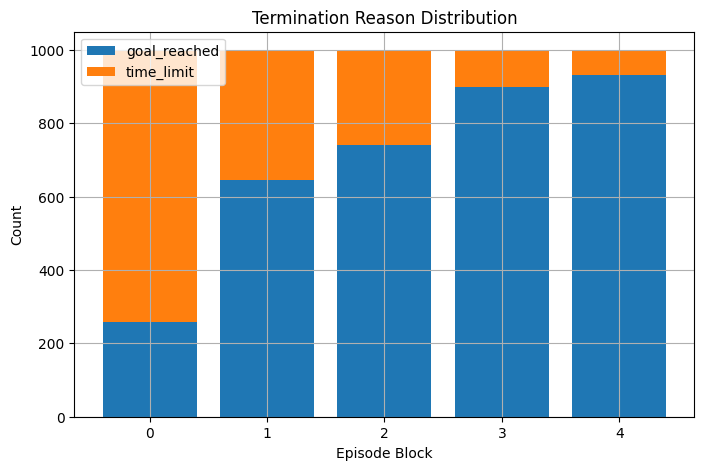

In [145]:
# 3) Gráficos (se guardan solo si OUT_DIR no es None)
plot_termination_stacks(df, block_size=1000, out_dir=OUT_DIR)

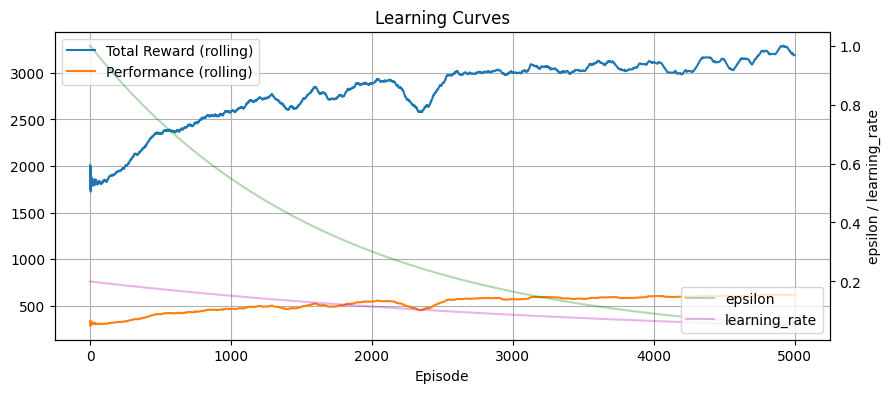

In [147]:
plot_learning_curves(df, window=200, out_dir=OUT_DIR)

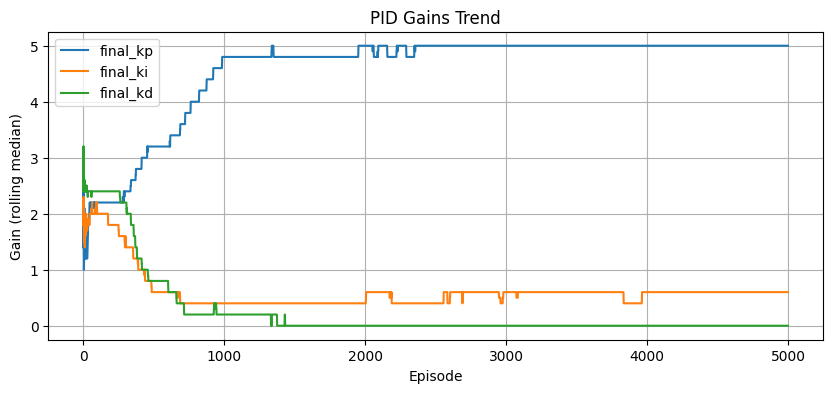

In [149]:
plot_gains_trends(df, window=200, out_dir=OUT_DIR)

C:\Users\davor\AppData\Local\Temp\ipykernel_63980\1812958696.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


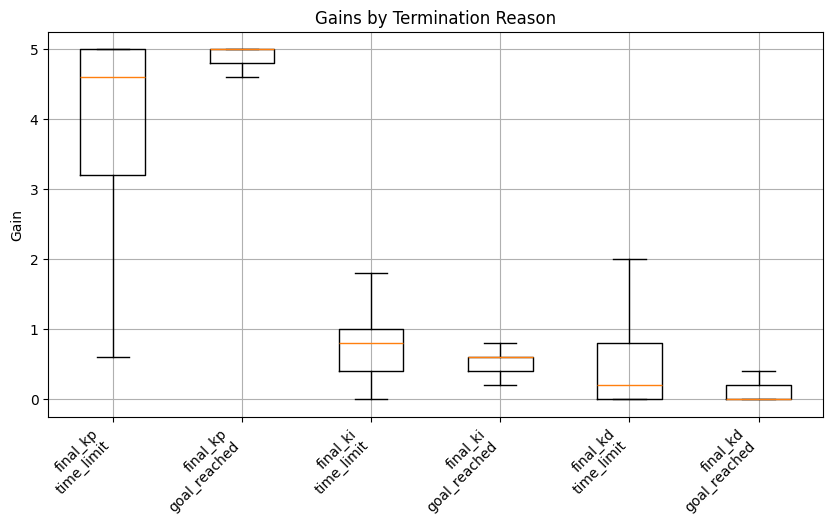

In [151]:
plot_gains_box_by_outcome(df, out_dir=OUT_DIR)

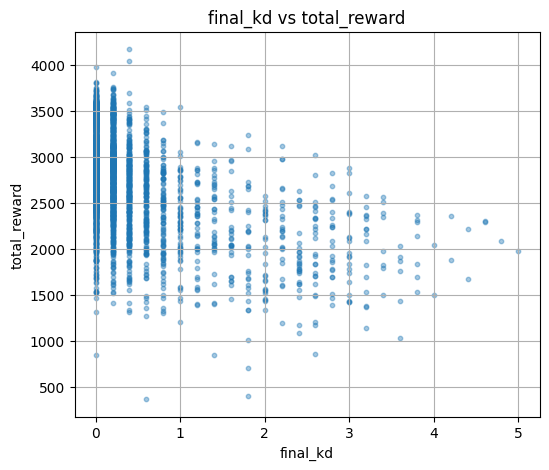

In [153]:
plot_kd_vs_reward(df, out_dir=OUT_DIR)

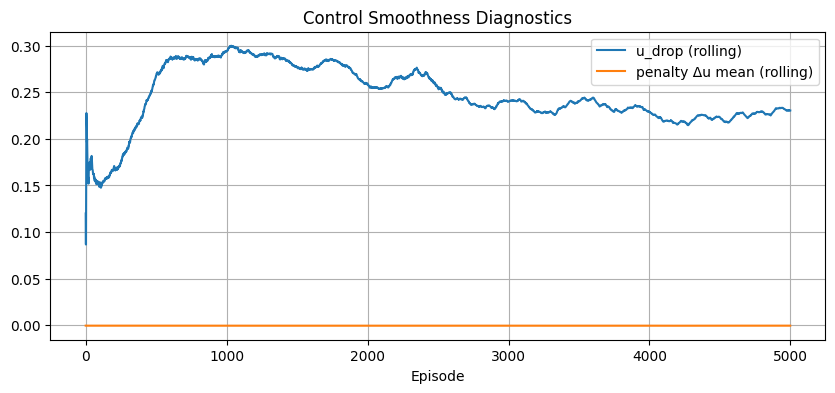

In [155]:
plot_u_diagnostics(df, window=200, out_dir=OUT_DIR)

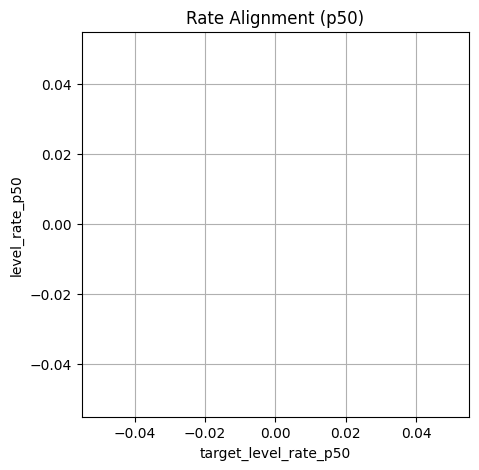

In [157]:
plot_rate_alignment(df, out_dir=OUT_DIR)

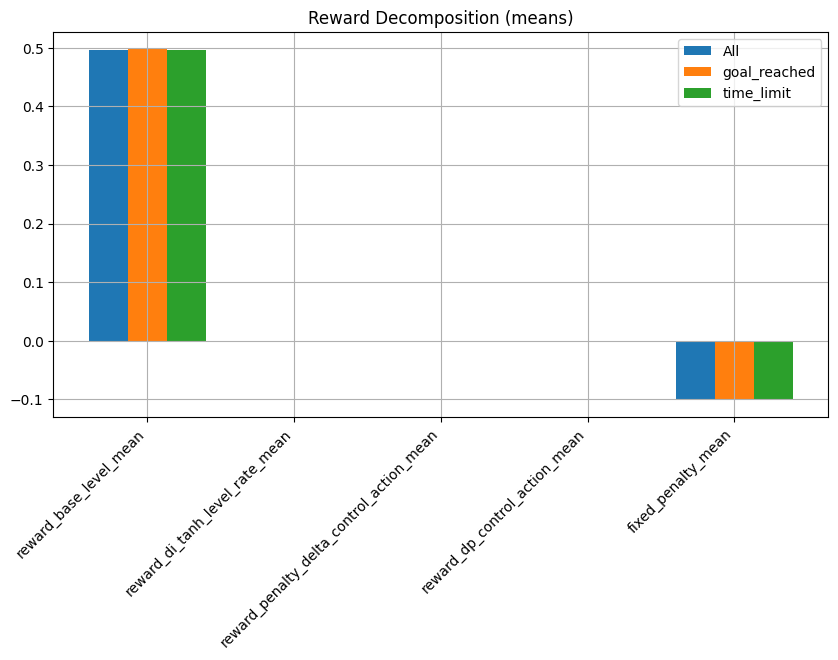

In [159]:
plot_reward_decomposition(df, out_dir=OUT_DIR)